In [64]:
import numpy as np 
import pandas as pd 
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import cv2
from keras.preprocessing import image

## Loading Data

In [133]:
covid_pneumonia_train = Path("/kaggle/input/covid-wwo-pneumonia-chest-xray/Data/train/covid_with_PNEUMONIA")
covid_non_pneumonia_train =Path("/kaggle/input/covid-wwo-pneumonia-chest-xray/Data/train/covid_without_PNEUMONIA")

covid_pneumonia_test = Path("/kaggle/input/covid-wwo-pneumonia-chest-xray/Data/test/covid_with_PNEUMONIA")
covid_non_pneumonia_test =Path("/kaggle/input/covid-wwo-pneumonia-chest-xray/Data/test/covid_without_PNEUMONIA")
images=[]
labels=[]

In [134]:
for i in covid_pneumonia_train.glob("*.jpeg"):
    image_data= image.load_img(i,color_mode='grayscale',target_size=(256,256),interpolation="bicubic")
    i_array= image.img_to_array(image_data)
    images.append(i_array)
    labels.append('covid_with_PNEUMONIA')

for i in covid_non_pneumonia_train.glob("*.jpeg"):
    
    image_data= image.load_img(i,color_mode='grayscale',target_size=(256,256),interpolation="bicubic")
    i_array= image.img_to_array(image_data)
    images.append(i_array)
    labels.append('covid_without_PNEUMONIA')

In [135]:
for i in covid_pneumonia_test.glob("*.jpeg"):
    image_data= image.load_img(i,color_mode='grayscale',target_size=(256,256),interpolation="bicubic")
    i_array= image.img_to_array(image_data)
    images.append(i_array)
    labels.append('covid_with_PNEUMONIA')

for i in covid_non_pneumonia_test.glob("*.jpeg"):
    
    image_data= image.load_img(i,color_mode='grayscale',target_size=(256,256),interpolation="bicubic")
    i_array= image.img_to_array(image_data)
    images.append(i_array)
    labels.append('covid_without_PNEUMONIA')

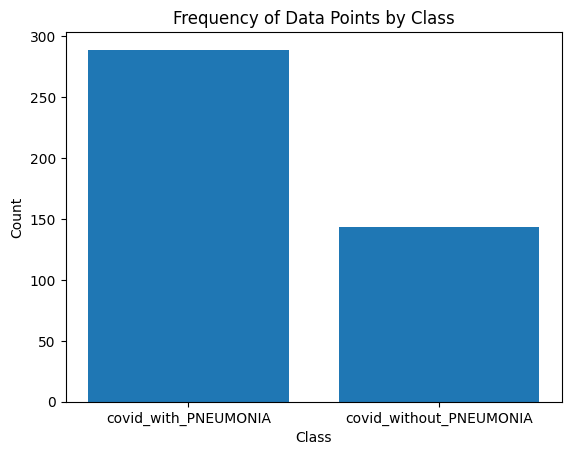

In [136]:
unique, counts = np.unique(labels, return_counts=True)
plt.bar(unique, counts, align='center')
plt.title('Frequency of Data Points by Class')
plt.ylabel('Count')
plt.xlabel('Class')
plt.xticks(['covid_without_PNEUMONIA','covid_with_PNEUMONIA'])
plt.show()

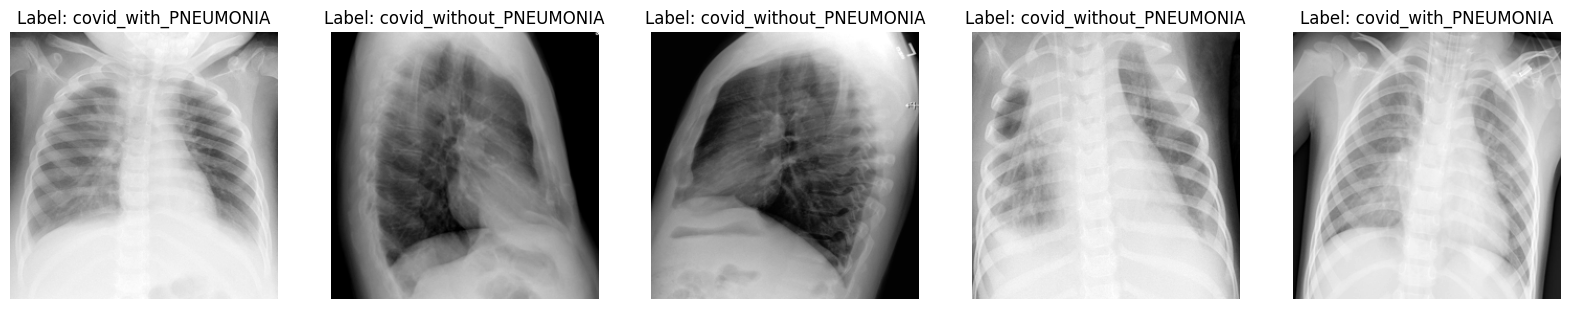

In [16]:
plt.figure(figsize=(20,7))
num_images = 5
for i in range(num_images):
    img = np.random.randint(1,432)
    plt.subplot(1,num_images,i+1)
    plt.imshow(images[img], cmap='gray')
    plt.title(f"Label: {labels[img]}")
    plt.axis('off')
plt.show()

## Data Preprocessing

In [137]:
def standardization(X_train, X_test):
    x_train = X_train / 255.0
    x_test= X_test / 255.0
    
    return x_train, x_test

In [138]:
def preprocessing(images, labels):
    
    X = np.array(images).reshape(len(images),256,256)
    y = np.where(np.array(labels)=='covid_with_PNEUMONIA',1,0)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
    
    X_train, X_test = standardization(X_train, X_test)
    
    return X_train, X_test, y_train, y_test

In [139]:
X_train, X_test, y_train, y_test = preprocessing(images, labels)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (345, 256, 256)
y_train shape: (345,)
X_test shape: (87, 256, 256)
y_test shape: (87,)


## Feature Extraction

### Centroid 

In [140]:
def extract_centroid_features(X, n_blocks):
    n_samples ,width, height = X.shape
    z = int(np.sqrt(n_blocks))
    block_dim = width // z
    extracted_features = np.zeros((n_samples,n_blocks*2))

    x = np.arange(width).reshape(-1,1)
    y = np.arange(height)

    for sample in range(n_samples):
        centroids = []
        for i in range(z):
            for j in range(z):
                if i == z-1 and j == z-1:
                    block = X[sample, i*block_dim:, j*block_dim:]
                    total_sum = np.sum(block)
                    if total_sum > 0:
                        x_bar = np.sum(x[i*block_dim:] * block) / total_sum
                        y_bar = np.sum(y[j*block_dim:]*block) / total_sum

                    else:
                        x_bar = y_bar = 0
                    centroids.append(x_bar)
                    centroids.append(y_bar)

                elif i == z-1:
                    block = X[sample, i*block_dim:, j*block_dim:(j+1)*block_dim]
                    total_sum = np.sum(block)
                    if total_sum > 0:
                        x_bar = np.sum(x[i*block_dim:]*block) / total_sum
                        y_bar = np.sum(y[j*block_dim:(j+1)*block_dim]*block) / total_sum
                    else:
                        x_bar = y_bar = 0
                    centroids.append(x_bar)
                    centroids.append(y_bar)


                elif j == z-1:
                    block = X[sample, i*block_dim:(i+1)*block_dim, j*block_dim:]
                    total_sum = np.sum(block)
                    if total_sum > 0:
                        x_bar = np.sum(x[i*block_dim:(i+1)*block_dim]*block) / total_sum
                        y_bar = np.sum(y[j*block_dim:]*block) / total_sum
                    else:
                        x_bar = y_bar = 0
                    centroids.append(x_bar)
                    centroids.append(y_bar)

                else:
                    block = X[sample,i*block_dim:(i+1)*block_dim,j*block_dim:(j+1)*block_dim]
                    total_sum = np.sum(block)
                    if total_sum > 0:
                        x_bar = np.sum(x[i*block_dim:(i+1)*block_dim]*block) / total_sum
                        y_bar = np.sum(y[j*block_dim:(j+1)*block_dim]*block) / total_sum
                    else:
                        x_bar = y_bar = 0
                    centroids.append(x_bar)
                    centroids.append(y_bar)

        extracted_features[sample] = np.array(centroids)

    return extracted_features

In [141]:
X_train_centroid =  extract_centroid_features(X_train,25)
X_test_centroid =  extract_centroid_features(X_test,25)

In [142]:
print(f"Number of Extracted Features: {X_train_centroid.shape[1]}")

Number of Extracted Features: 50


## Feature Reduction

### LDA 

In [143]:
class LDA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.top_eigen = None
        self.class_means = None
    
    def _calculate_within_class_scatter(self, X, y):

        self.class_means = {}
        classes =  np.unique(y)
        for label in classes:
            self.class_means[label] = np.mean(X[y == label], axis=0)
        
        Sw = np.zeros((X.shape[1], X.shape[1]))
        for label in classes:
            
            class_data = X[y == label]
            diff = class_data - self.class_means[label]
            Sw += np.dot(diff.T, diff)
            
        return Sw
    
    def _calculate_between_class_scatter(self, X, y):

        overall_mean = np.mean(X, axis=0)
        Sb = np.zeros((X.shape[1], X.shape[1]))
        
        for label in self.class_means:
            n = X[y == label].shape[0]
            diff = (self.class_means[label] - overall_mean).reshape(-1, 1)
            Sb += n * np.dot(diff, diff.T)
        return Sb
    
    def fit(self, X, y):
        # Calculate scatter matrices
        Sw = self._calculate_within_class_scatter(X, y)
        Sb = self._calculate_between_class_scatter(X, y)
        
        # Solve the eigenvalue problem: Sw^-1 * Sb
        eigenvalues, eigenvectors = np.linalg.eig(np.linalg.inv(Sw).dot(Sb))
        
        # Sort eigenvalues and eigenvectors
        idx = np.argsort(eigenvalues)[::-1]
        self.top_eigen = eigenvectors[:, idx[:self.n_components]]
        
    
    def transform(self, X):
        return np.dot(X, self.top_eigen)


In [144]:
lda = LDA(n_components=10)
lda.fit(X_train_centroid, y_train)

In [145]:
X_train_lda = lda.transform(X_train_centroid)
X_test_lda = lda.transform(X_test_centroid)
print(f"Transformed shape: {X_train_lda.shape}")

Transformed shape: (345, 10)


## Feature Selection

In [146]:
class GaussianNaiveBayes:

    def __init__(self):
        self.mean = {}
        self.var = {}
        self.prior = {}
        self.posterior = {}

    def fit(self, X, y):
        self.classes = np.unique(y)
        n_samples = X.shape[0]

        for c in self.classes:
            X_c = X[y == c]
            self.mean[c] = X_c.mean(axis=0)
            self.var[c] =  X_c.var(axis=0)
            # frequency of each class
            self.prior[c] = len(X_c) / n_samples

    def calculate_likelihood(self, x, mean, var):
        exponent = np.exp(-((x - mean) ** 2) / (2 * var))
        return np.prod((exponent / np.sqrt(2 * np.pi * var)))

    def predict(self, X):
        predictions = []
        for x in X:
            for c in self.classes:
                likelihood = self.calculate_likelihood(x, self.mean[c], self.var[c])
                self.posterior[c] = likelihood * self.prior[c]
            predictions.append(max(self.posterior, key=self.posterior.get))
        return predictions
    
    def accuracy(self, y_pred, y_true):
        return np.mean(y_pred == y_true)

In [147]:
def pso_feature_selection(X, y, n_particles=50, max_iter=50, w=0.8, c1=0.1, c2=0.1):
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1234)
    # Initialize particles with random feature subsets
    particles = np.random.choice([0, 1], size=(n_particles, X_train.shape[1]))

    # Initialize velocities
    velocities = np.zeros_like(particles)

    # Initialize best positions and best fitness
    local_best_positions = particles.copy()
    local_best_fitness = np.zeros(n_particles)
    global_best_position = None
    global_best_fitness = -np.inf

    # PSO main loop
    for _ in range(max_iter):
        for i, particle in enumerate(particles):
            # Evaluate fitness
            selected_features = X_train[:, particle.astype(bool)]
            clf = GaussianNaiveBayes() # You can use any classifier here
            clf.fit(selected_features, y_train)
            y_pred = clf.predict(X_val[:, particle.astype(bool)])
            fitness = accuracy_score(y_val, y_pred)

            # Update local best
            if fitness > local_best_fitness[i]:
                local_best_fitness[i] = fitness
                local_best_positions[i] = particle.copy()

                # Update global best
                if fitness > global_best_fitness:
                    global_best_fitness = fitness
                    global_best_position = particle.copy()

        # Update velocities and positions
        r1 = np.random.rand(n_particles, particles.shape[1])
        r2 = np.random.rand(n_particles, particles.shape[1])
        velocities = w * velocities + c1 * r1 * (local_best_positions - particles) + c2 * r2 * (global_best_position - particles)
        particles = particles + velocities

    return global_best_position

In [152]:
selected_features = pso_feature_selection(X_train_lda, y_train, n_particles=25, max_iter=50, w=0.8, c1=0.1, c2=0.1)

In [153]:
X_train_selected = X_train_lda[:, selected_features.astype(bool)]
X_test_selected = X_test_lda[:, selected_features.astype(bool)]
print(f"Number of Selected Features: {X_train_selected[1].shape}")

Number of Selected Features: (5,)


## Classification

In [154]:
model = GaussianNaiveBayes()
model.fit(X_train_selected, y_train)

In [155]:
y_pred = model.predict(X_test_selected)
accuracy = model.accuracy(y_pred,y_test)
print(f"Accuracy: {accuracy*100:0.2f}")

Accuracy: 93.10


In [156]:
from sklearn.metrics import classification_report
target_names = ["Class 0", "Class 1"]Z
print(classification_report(y_test,y_pred, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.92      0.85      0.88        26
     Class 1       0.94      0.97      0.95        61

    accuracy                           0.93        87
   macro avg       0.93      0.91      0.92        87
weighted avg       0.93      0.93      0.93        87



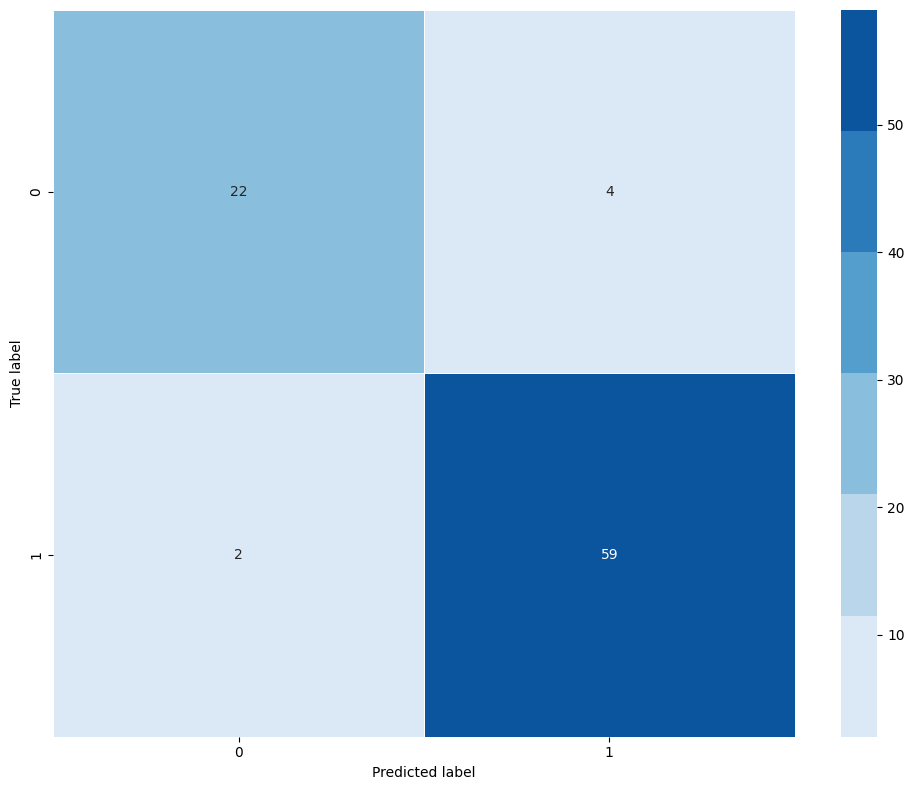

In [157]:
cm= confusion_matrix(y_test,y_pred,labels=[0,1])
fig, ax = plt.subplots(figsize=(10,8))

sns.heatmap(cm, annot=True,ax=ax,fmt="d",linewidths=.5,cmap=sns.color_palette("Blues"))
ax.set(xlabel='Predicted label', ylabel='True label')
plt.tight_layout()
plt.show()